# tscluster Tutorial

In [1]:
## Importing Libraries

In [2]:
%matplotlib widget

import os 

os.chdir("..")

import numpy as np
import pandas as pd

from tscluster.opttscluster import OptTSCluster
from tscluster.tskmeans import TSKmeans, TSGlobalKmeans
from tscluster.preprocessing import TSStandardScaler, TSMinMaxScaler
from tscluster.preprocessing.utils import load_data, tnf_to_ntf, ntf_to_tnf, to_dfs, broadcast_data
from tscluster.metrics import inertia, max_dist
from tscluster.tsplot import tsplot

## Loading Data

In [3]:
os.chdir("./test/sample_data")

### from a npy file

If data is a numpy array stored as a `.npy` file, you can use the `load_data` function to load it.

In [4]:
X, label_dict = load_data("./sythetic_data.npy")
X.shape

(10, 15, 1)

The `load_data` function returns a tuple, the first value of the tuple is the loaded data (a 3-D array in 'TNF' format), while the second value of the tuple is the label_dict of the data. The `label_dict` is a dictionary whose keys are 'T', 'N', and 'F' (which are the number of time steps, entities, and features respectively). Value of each key is a list such that the value of key:
 - 'T' is a list of names/labels of each time step to be used as index of each dataframe. If None, range(0, T) is used. Where T is the number of time steps in the fitted data
 - 'N' (ignored) is a list of names/labels of each entity. If None, range(0, N) is used. Where N is the number of entities/observations in the fitted data 
 - 'F' is a list of names/labels of each feature to be used as column of each dataframe. If None, range(0, F) is used. Where F is the number of features in the fitted data 
   

In [5]:
print(label_dict)

{'T': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'F': [0]}


### from a list

Data can also be loaded from a list. This can be a list of 2-D numpy arrays, or list of pandas dataframes, or list of file paths. By default, the list is of length `T` (number of time steps), where each element of the list is interpreted as a data for all entities at a particular time step. Set the `arr_format` parameter to 'NTF' to specify that each element of the input list is the time series data for a particular entity for all time steps. Valid files are `.npy`, `.npz`, `.json`, `xlsx`, `.csv` or any file readable by `pandas.read_csv` function.

In [6]:
df1 = pd.DataFrame({
    'f1': np.arange(5),
    'f2': np.arange(5, 10)
}, index=['e'+str(i+1) for i in range(5)]
                  )
df1

f1  f2
e1   0   5
e2   1   6
e3   2   7
e4   3   8
e5   4   9

In [7]:
df2 = pd.DataFrame({
    'f2': np.arange(105, 110),
    'f1': np.arange(100, 105)
}, index=['e'+str(i+1) for i in range(5)]
                  )
df2

f2   f1
e1  105  100
e2  106  101
e3  107  102
e4  108  103
e5  109  104

In [8]:
X_arr, label_dict = load_data([df1, df2])
print(f"shape of X_arr is {X_arr.shape}")
X_arr

shape of X_arr is (2, 5, 2)


array([[[  0,   5],
        [  1,   6],
        [  2,   7],
        [  3,   8],
        [  4,   9]],

       [[100, 105],
        [101, 106],
        [102, 107],
        [103, 108],
        [104, 109]]])

In [9]:
label_dict

{'T': [0, 1], 'N': ['e1', 'e2', 'e3', 'e4', 'e5'], 'F': ['f1', 'f2']}

To get the output in 'NTF' format, set the `output_arr_format` parameter to 'NTF'

In [10]:
X_arr, label_dict = load_data([df1, df2], output_arr_format='NTF')
print(f"shape of X_arr is {X_arr.shape}")
X_arr

shape of X_arr is (5, 2, 2)


array([[[  0.,   5.],
        [100., 105.]],

       [[  1.,   6.],
        [101., 106.]],

       [[  2.,   7.],
        [102., 107.]],

       [[  3.,   8.],
        [103., 108.]],

       [[  4.,   9.],
        [104., 109.]]])

In [11]:
label_dict # label_dict will remain the same

{'T': [0, 1], 'N': ['e1', 'e2', 'e3', 'e4', 'e5'], 'F': ['f1', 'f2']}

The same applies to list of file paths. E.g.

In [12]:
file_list = [
    "./synthetic_csv/timestep_0.csv",
    "./synthetic_csv/timestep_1.csv",
    "./synthetic_csv/timestep_2.csv",
    "./synthetic_csv/timestep_3.csv",
    "./synthetic_csv/timestep_4.csv"
]

X_arr, label_dict = load_data(file_list)
print(f"shape of X_arr is {X_arr.shape}")

shape of X_arr is (5, 20, 2)


In [13]:
label_dict

{'T': [0, 1, 2, 3, 4],
 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'F': [0, 1]}

You can also pass arguments to the file reader used by using the `read_file_args` parameter. This parameter accepts a dictionary where the keys are the names of the file reader parameters (in string), and the values are the values of the file reader parameter. E.g. if file reader is pd.read_csv (reader for csv file), you can pass `names` and `skiprows` arguments (and basically any argument you want to pass to the file reader).

In [14]:
file_list = [
    "./synthetic_csv/timestep_0.csv",
    "./synthetic_csv/timestep_1.csv",
    "./synthetic_csv/timestep_2.csv",
    "./synthetic_csv/timestep_3.csv",
    "./synthetic_csv/timestep_4.csv"
]

X_arr, label_dict = load_data(file_list, read_file_args={'names': ['x1', 'x2'], 'skiprows': 10})
print(f"shape of X_arr is {X_arr.shape}")

shape of X_arr is (5, 10, 2)


In [15]:
label_dict

{'T': [0, 1, 2, 3, 4], 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'F': ['x1', 'x2']}

### from a directory

You can instead pass a directory path (as a string) to the `load_data` function. In this case, the suffix (not file extension) of the filenames will be used for ordering the files before loading them as different timesteps. The suffix consists of characters after `suffix_sep` (not including file extension). The default value for `suffix_sep` is an undescore "_". E.g. if the 'synthetic_csv' directory contains the following files:

- timestep_1.csv
- timestep_2.csv
- timestep_3.csv
- timestep_4.csv

We can read the files as follows:

In [16]:
X_arr, label_dict = load_data('./synthetic_csv')
print(f"shape of X_arr is {X_arr.shape}")

shape of X_arr is (5, 20, 2)


In [17]:
label_dict

{'T': [0, 1, 2, 3, 4],
 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 'F': [0, 1]}

In [18]:
# for j, f in enumerate(file_list):
#     d = pd.read_csv(f, header=None).head(10)
#     d.index = ['i'+str(i+1) for i in range(d.shape[0])]
#     d.columns = ['x1', 'x2']
#     d.to_csv(f"./synthetic_csv2/year-{np.arange(2000, 2021, 5)[j]}.csv")
# d.head()

The suffixes of the filenames may not neccessarily start from 1 or have an interval of 1. For example, the filenames could be:

- year-2000.csv
- year-2005.csv
- year-2010.csv
- year-2015.csv
- year-2020.csv

So long the suffixes can be sorted and there is a consistent suffix separator ("-" is this case), the directory can be parsed by `load_data` function. 

In [19]:
# checking how the head of a single 
pd.read_csv('./synthetic_csv2/year-2005.csv').head()

Unnamed: 0        x1        x2        x3
0         i1  1.144403  1.384766 -0.296697
1         i2 -0.221455 -2.379010  1.616871
2         i3  1.533177 -1.650524 -0.548531
3         i4 -0.615204  0.794567 -0.726242
4         i5  0.622818 -0.129735 -0.723215

In [20]:
# if we were to indicate to pandas that the first column is the index and the first row is the header, we would have done
pd.read_csv('./synthetic_csv2/year-2005.csv', index_col=[0], header=0).head()

x1        x2        x3
i1  1.144403  1.384766 -0.296697
i2 -0.221455 -2.379010  1.616871
i3  1.533177 -1.650524 -0.548531
i4 -0.615204  0.794567 -0.726242
i5  0.622818 -0.129735 -0.723215

In [21]:
# using load_data function
X_arr, label_dict = load_data('./synthetic_csv2', 
                              suffix_sep='-', 
                              use_suffix_as_label=True,
                              read_file_args={'index_col': [0], 'header': 0})
print(f"shape of X_arr is {X_arr.shape}")

shape of X_arr is (5, 10, 3)


In [22]:
print(label_dict)

{'T': ['2000', '2005', '2010', '2015', '2020'], 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'], 'F': ['x1', 'x2', 'x3']}


## Data Conversion

### to_dfs

We can convert a 3-D array to a list of dataframes using the `to_dfs` function. This is basically the reverse process of `load_dict` in that it takes a 3-D array and an optional label_dict, and returns a list of dataframes. Similar to `load_dict` function, you can use `arr_format` and `output_df_format` to specify the format of the input data and output data respectively.

In [23]:
dfs = to_dfs(X_arr, label_dict)
print(f"Length of dfs is: {len(dfs)}")
dfs[0].head() # first five rows of the first dataframe in the list

Length of dfs is: 5


x1        x2        x3
i1   0.496714 -0.138264 -0.291524
i10  0.097078  0.968645  0.626228
i2  -0.463418 -0.465730 -0.312976
i3   1.465649 -0.225776  0.488591
i4  -0.601707  1.852278 -0.078235

### tnf_to_ntf

`tnf_to_ntf` function can be used to convert a data from 'TNF' format to 'NTF' format. E.g

In [24]:
print(f"Shape of X_arr in 'TNF' format is: {X_arr.shape}")

X_arr_ntf = tnf_to_ntf(X_arr)

print(f"Shape of X_arr in 'NTF' format is: {X_arr_ntf.shape}")

Shape of X_arr in 'TNF' format is: (5, 10, 3)
Shape of X_arr in 'NTF' format is: (10, 5, 3)


### ntf_to_tnf

Similarly, `ntf_to_tnf` function can be used to convert from 'NTF' format to 'TNF' format. E.g.

In [25]:
print(f"Shape of X_arr in 'NTF' format is: {X_arr_ntf.shape}")

print(f"Shape of X_arr in 'TNF' format is: {ntf_to_tnf(X_arr_ntf).shape}")

Shape of X_arr in 'NTF' format is: (10, 5, 3)
Shape of X_arr in 'TNF' format is: (5, 10, 3)


### broadcast_data

If you want to broadcast a fixed cluster center along the time axis, you can use `broadcast_data` function. E.g. if you have fixed cluster centers as a 2-D array of shape (K, F), where K is the number of clusters and F is the number of features; you can convert it to a 3-D array such that the first axis is the time axis. This is usefule especially when dealing with fixed center or fixed assignment because they return (for memory efficiency) a 2-D array and a 1-D array respectively.

In [26]:
np.random.seed(0)
cluster_centers = np.random.randn(3, 2)
cluster_centers

array([[ 1.76405235,  0.40015721],
       [ 0.97873798,  2.2408932 ],
       [ 1.86755799, -0.97727788]])

In [27]:
T = 3 # number of time steps
cluster_centers_broadcasted, _ = broadcast_data(T, cluster_centers=cluster_centers)
cluster_centers_broadcasted

array([[[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]],

       [[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]],

       [[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]]])

You can also broadcast labels. E.g  if the cluster labels is a 1-D numpy array of shape (N, ).

In [28]:
np.random.seed(2)
labels = np.random.choice([0, 1, 2], 10)
labels

array([0, 1, 0, 2, 2, 0, 2, 1, 1, 2])

In [29]:
T = 3 # number of time steps
_, labels_broadcasted = broadcast_data(T, labels=labels)
labels_broadcasted

array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [2, 2, 2],
       [2, 2, 2],
       [0, 0, 0],
       [2, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       [2, 2, 2]])

You can also broadcast both cluster_centers and labels at the same time

In [30]:
T = 3 # number of time steps
cluster_centers_broadcasted, labels_broadcasted = broadcast_data(T, cluster_centers=cluster_centers, labels=labels)
cluster_centers_broadcasted

array([[[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]],

       [[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]],

       [[ 1.76405235,  0.40015721],
        [ 0.97873798,  2.2408932 ],
        [ 1.86755799, -0.97727788]]])

In [31]:
labels_broadcasted

array([[0, 0, 0],
       [1, 1, 1],
       [0, 0, 0],
       [2, 2, 2],
       [2, 2, 2],
       [0, 0, 0],
       [2, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       [2, 2, 2]])

## Preprocessing

The `preprocessing` module has two main scalers: `TSStandardScaler` and `TSMinMaxScaler`.

### TSStandardScaler

This scaler uses sklearn's StandardScaler to scale a time series data. Scaling can be done per timesteps (default) or per feature 

Using `fit` and `transform` methods.
During `fit`, the scaler parameters are stored. They will be used for `tranform` and `inverse-tansform` of data.

In [32]:
scaler = TSStandardScaler(per_time=True) # initialize a time series standard scaler
scaler.fit(X_arr) # fit 
X_scaled = scaler.fit_transform(X_arr) # transform 
print(f"X_scaled shape is {X_scaled.shape}")
print()
print("First five entities for the first time step are:")
print(X_scaled[0, :5, :])

X_scaled shape is (5, 10, 3)

First five entities for the first time step are:
[[ 0.53075651 -0.62117007 -0.2344527 ]
 [-0.12234591  0.79082039  0.91426627]
 [-1.03833007 -1.03889002 -0.26130345]
 [ 2.11422893 -0.73280172  0.74199078]
 [-1.26432746  1.91799644  0.03251411]]


`fit` and `transform` can be done with a single method called `fit_transform`. E.g.

In [33]:
scaler = TSStandardScaler(per_time=True) # initialize a time series standard scaler
X_scaled = scaler.fit_transform(X_arr) # fit and transform at the same time
print(f"X_scaled shape is {X_scaled.shape}")
print()
print("First five entities for the first time step are:")
print(X_scaled[0, :5, :])

X_scaled shape is (5, 10, 3)

First five entities for the first time step are:
[[ 0.53075651 -0.62117007 -0.2344527 ]
 [-0.12234591  0.79082039  0.91426627]
 [-1.03833007 -1.03889002 -0.26130345]
 [ 2.11422893 -0.73280172  0.74199078]
 [-1.26432746  1.91799644  0.03251411]]


We can use `inverse-tranform` method to reverse the transformation.

In [34]:
print("First five entities for the first time step of the original data are:")
print(X_arr[0, :5, :])
print()
print("First five entities for the first time step of the inverse tranform of X_scaled are:")
print(scaler.inverse_transform(X_scaled)[0, :5, :])

First five entities for the first time step of the original data are:
[[ 0.49671415 -0.1382643  -0.29152375]
 [ 0.09707755  0.96864499  0.62622751]
 [-0.46341769 -0.46572975 -0.31297574]
 [ 1.46564877 -0.2257763   0.48859067]
 [-0.60170661  1.85227818 -0.07823474]]

First five entities for the first time step of the inverse tranform of X_scaled are:
[[ 0.49671415 -0.1382643  -0.29152375]
 [ 0.09707755  0.96864499  0.62622751]
 [-0.46341769 -0.46572975 -0.31297574]
 [ 1.46564877 -0.2257763   0.48859067]
 [-0.60170661  1.85227818 -0.07823474]]


### TSMinMaxScaler

The same methods of `TSStandardScaler` applies to `TSMinMaxScaler`

This scaler uses sklearn's MinMaxScaler to scale a time series data. Scaling can be done per timesteps (default) or per feature 

Using `fit` and `transform` methods.

During `fit`, the scaler parameters are stored. They will be used for `tranform` and `inverse-tansform` of data.

In [35]:
scaler = TSMinMaxScaler(per_time=True) # initialize a time series minmax scaler
scaler.fit(X_arr) # fit 
X_scaled = scaler.fit_transform(X_arr) # transform 
print(f"X_scaled shape is {X_scaled.shape}")
print()
print("First five entities for the first time step are:")
print(X_scaled[0, :5, :])

X_scaled shape is (5, 10, 3)

First five entities for the first time step are:
[[0.53131686 0.1412702  0.40094123]
 [0.33800873 0.6187963  0.75951472]
 [0.0668917  0.         0.39255975]
 [1.         0.1035171  0.7057388 ]
 [0.         1.         0.48427512]]


`fit` and `transform` can be done with a single method called `fit_transform`. E.g.

In [36]:
scaler = TSMinMaxScaler(per_time=True) # initialize a time series minmax scaler
X_scaled = scaler.fit_transform(X_arr) # fit and transform at the same time
print(f"X_scaled shape is {X_scaled.shape}")
print()
print("First five entities for the first time step are:")
print(X_scaled[0, :5, :])

X_scaled shape is (5, 10, 3)

First five entities for the first time step are:
[[0.53131686 0.1412702  0.40094123]
 [0.33800873 0.6187963  0.75951472]
 [0.0668917  0.         0.39255975]
 [1.         0.1035171  0.7057388 ]
 [0.         1.         0.48427512]]


We can use `inverse-tranform` method to reverse the transformation.

In [37]:
print("First five entities for the first time step of the original data are:")
print(X_arr[0, :5, :])
print()
print("First five entities for the first time step of the inverse tranform of X_scaled are:")
print(scaler.inverse_transform(X_scaled)[0, :5, :])

First five entities for the first time step of the original data are:
[[ 0.49671415 -0.1382643  -0.29152375]
 [ 0.09707755  0.96864499  0.62622751]
 [-0.46341769 -0.46572975 -0.31297574]
 [ 1.46564877 -0.2257763   0.48859067]
 [-0.60170661  1.85227818 -0.07823474]]

First five entities for the first time step of the inverse tranform of X_scaled are:
[[ 0.49671415 -0.1382643  -0.29152375]
 [ 0.09707755  0.96864499  0.62622751]
 [-0.46341769 -0.46572975 -0.31297574]
 [ 1.46564877 -0.2257763   0.48859067]
 [-0.60170661  1.85227818 -0.07823474]]


## Metrics

There are currently two metrics in `tscluster` package: `inertia` and `max_dist`.

The inertia is calculated as: 
$$
    \sum_{t=1}^{T} \sum_{i=1}^{N} D(X_{ti}, Z_t) 
$$
Where 
- $T$, $N$ are the number of time steps and entities respectively 
- $D$ is a distance function (or metric e.g $L_1$ distance, $L_2$ distance etc)
- $f$ is the number of features 
- $X_{ti} \in \mathbf{R}^f$ is the feature vector of entity $i$ at time $t$
- $Z_t \in \mathbf{R}^f$ is the cluster center $X_{ti}$ is assigned to at time $t$

The max_dist is calculated as: 
$$
    max(D(X_{ti}, Z_t)) 
$$
Where 
- $D$ is a distance function (or metric e.g $L_1$distance, $L_2$ distance etc)
- $f$ is the number of features
- $X_{ti} \in \mathbf{R}^f$ is the feature vector of entity $i$ at time $t$,
- $Z_t \in \mathbf{R}^f$ is the cluster center $X_{ti}$ is assigned to at time $t$.

Both `inertia` and `max_dist` functions take four arguments: 
1. The data X (in TNF format)
2. cluster_centers
3. labels
4. ord (which specifies the order of the Minkowski distance)

They can also take both 3-D and 2-D arrays for dynamic and fixed cluster centers respectively, and 2-D and 1-D arrays for dynamic and fixed labels respectively.

In [38]:
# using fixed cluster centers and dynamic label assignment
np.random.seed(0)
cluster_centers = np.random.randn(3, X_arr.shape[2]) # 2-D array (for fixed cluster)

np.random.seed(2)
labels = np.random.choice([0, 1, 2], (X_arr.shape[1], X_arr.shape[0])) # 2-D array (for dynamic labels)

In [39]:
print(f"inertia score is {inertia(X_arr, cluster_centers, labels, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr, cluster_centers, labels, ord=1)}") # using l1 distance

inertia score is 217.22127047719061
max_dist score is 10.202923513064336


In [40]:
# using dynamic cluster centers and fixed label assignment
np.random.seed(0)
cluster_centers = np.random.randn(X_arr.shape[0], 3, X_arr.shape[2]) # 3-D array (for dynamic cluster)

np.random.seed(2)
labels = np.random.choice([0, 1, 2], X_arr.shape[1]) # 1-D array (for fixed labels)
labels

array([0, 1, 0, 2, 2, 0, 2, 1, 1, 2])

In [41]:
print(f"inertia score is {inertia(X_arr, cluster_centers, labels, ord=2)}") # using l2 distance
print(f"max_dist score is {max_dist(X_arr, cluster_centers, labels, ord=2)}") # using l2 distance

inertia score is 138.29240897541072
max_dist score is 7.3157146070128745


## TSPlot

### plot

`plot` function is used to plot a time series plots of the different features in a time series data

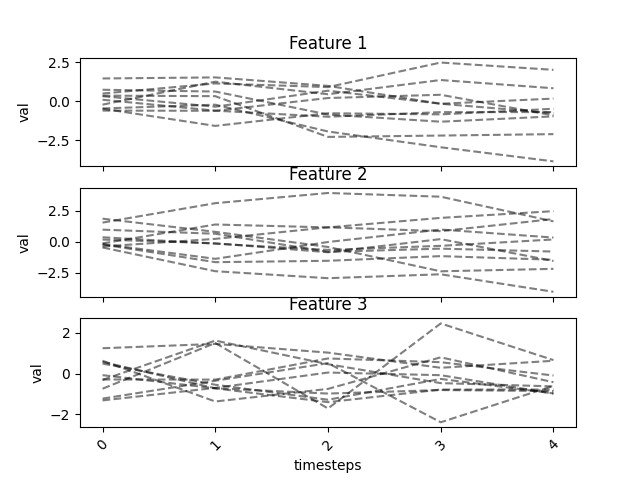

In [42]:
fig, ax = tsplot.plot(X=X_arr)

We can add label assignment to the plot

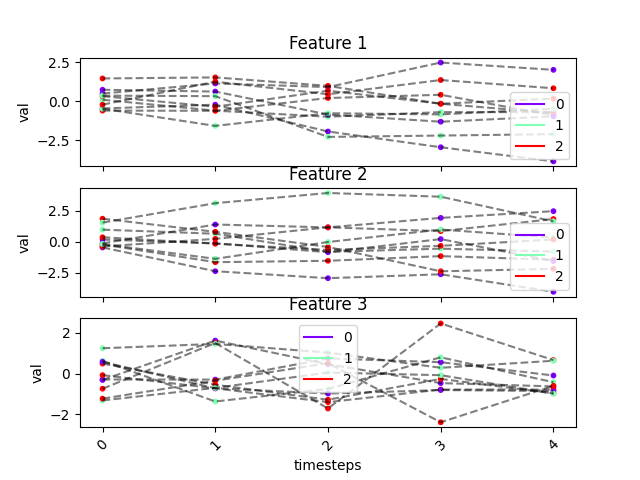

In [43]:
fig, ax = tsplot.plot(X=X_arr, labels=labels)

We can plot only cluster centers

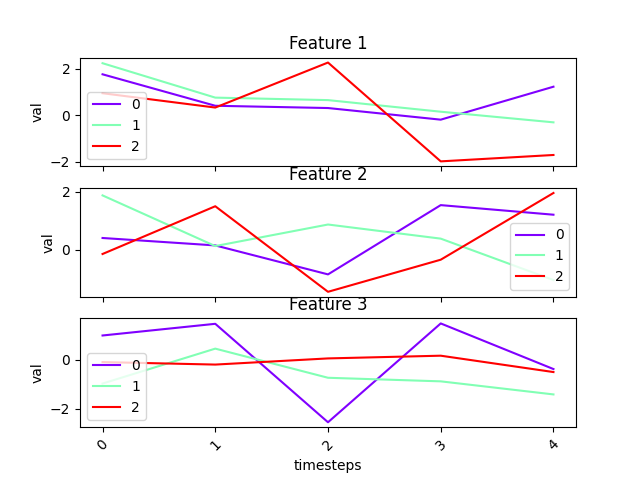

In [44]:
fig, ax = tsplot.plot(cluster_centers=cluster_centers)

We can plot all of data X, cluster centers and label assignment in the same plot

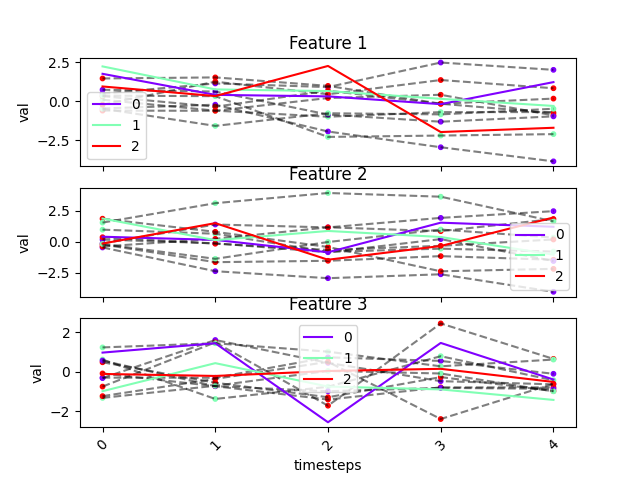

In [45]:
fig, ax = tsplot.plot(X=X_arr, cluster_centers=cluster_centers, labels=labels) 
# note that the cluster centers are not meaningfull since they were randomly generated

We can also annotate only specific entities by passing their index to the `entity_idx` parameter

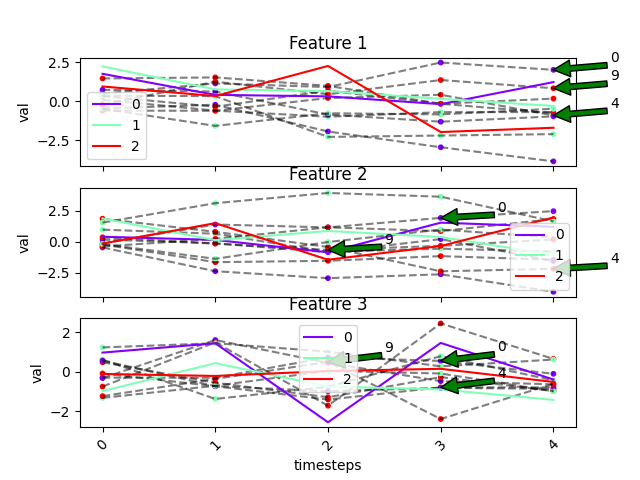

In [46]:
fig, ax = tsplot.plot(X=X_arr, cluster_centers=cluster_centers, labels=labels, entity_idx=[0, 4, 9]) 

We can show only the entities in `entity_idx` by setting `show_all_entities` to False

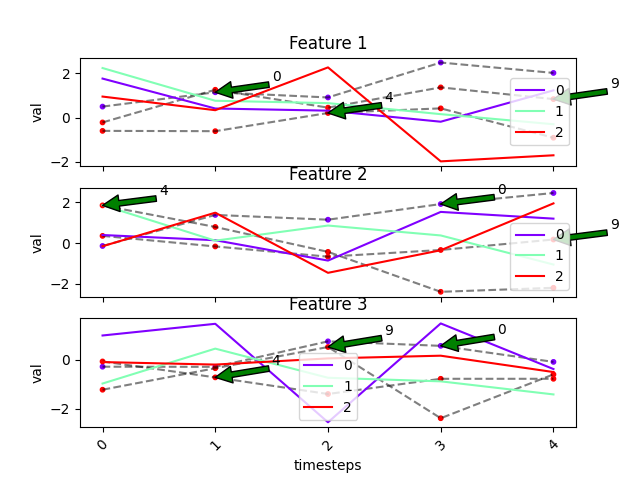

In [47]:
fig, ax = tsplot.plot(X=X_arr, cluster_centers=cluster_centers, labels=labels, entity_idx=[0, 4, 9], show_all_entities=False) 

We can use the labels in label_dict to label the entities in `entity_idx` by passing `label_dict`

In [48]:
# recall our label dict
label_dict

{'T': ['2000', '2005', '2010', '2015', '2020'],
 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
 'F': ['x1', 'x2', 'x3']}

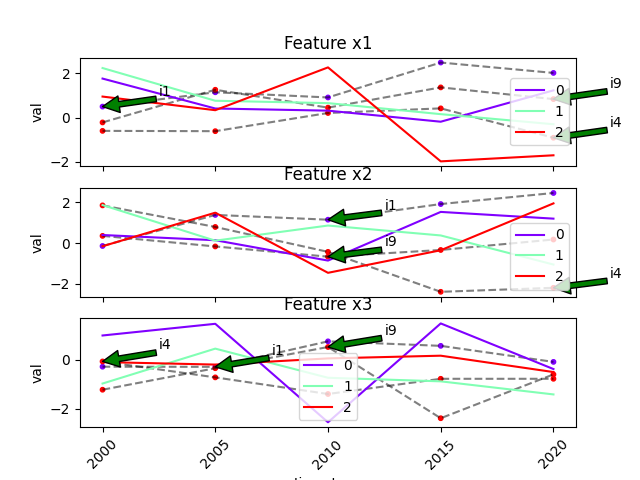

In [49]:
fig, ax = tsplot.plot(
    X=X_arr, 
    cluster_centers=cluster_centers, 
    labels=labels, 
    entity_idx=[0, 4, 9], 
    show_all_entities=False,
    label_dict=label_dict
) 

We can pass custom labels to the labels in `entity_idx` using the `entities_labels` parameter.

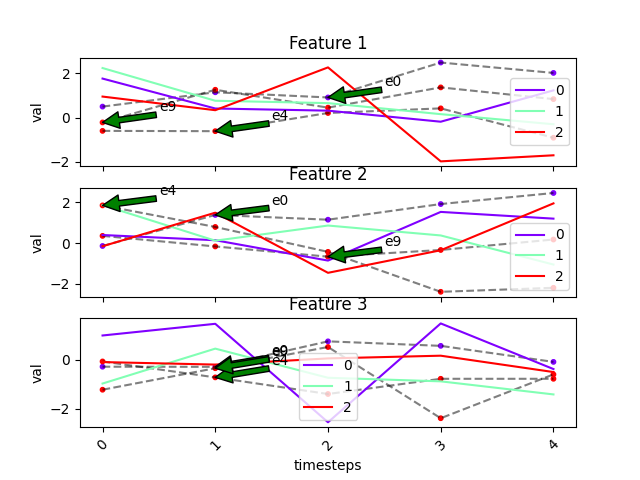

In [50]:
fig, ax = tsplot.plot(
    X=X_arr, 
    cluster_centers=cluster_centers, 
    labels=labels, 
    entity_idx=[0, 4, 9], 
    entities_labels=['e0', 'e4', 'e9'],
    show_all_entities=False
) 

We can also pass custom labels for the cluster centers using the `cluster_labels` parameter

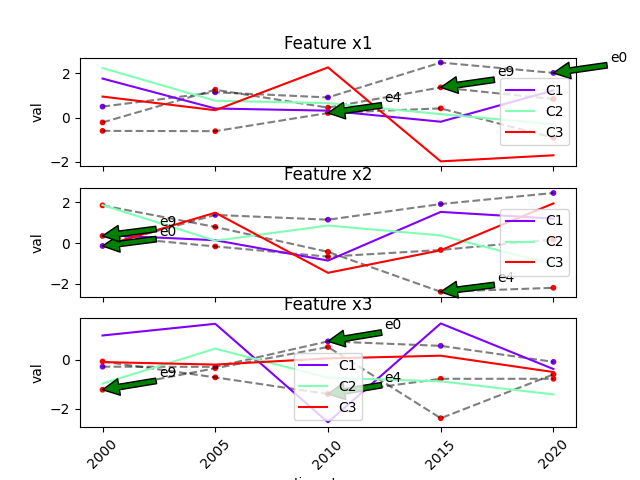

In [51]:
fig, ax = tsplot.plot(
    X=X_arr, 
    cluster_centers=cluster_centers, 
    labels=labels, 
    entity_idx=[0, 4, 9], 
    entities_labels=['e0', 'e4', 'e9'],
    show_all_entities=False,
    label_dict=label_dict,
    cluster_labels=['C1', 'C2', 'C3']
) 

### waterfall_plot

`waterfall_plot` can be used to generate a 3-D time series plot of a particular entity or cluster center.

To make the plot interactive, use a suitable matplotlib's magic command. E.g. `%matplotlib widget`. See this site for more: https://matplotlib.org/stable/users/explain/figure/interactive.html

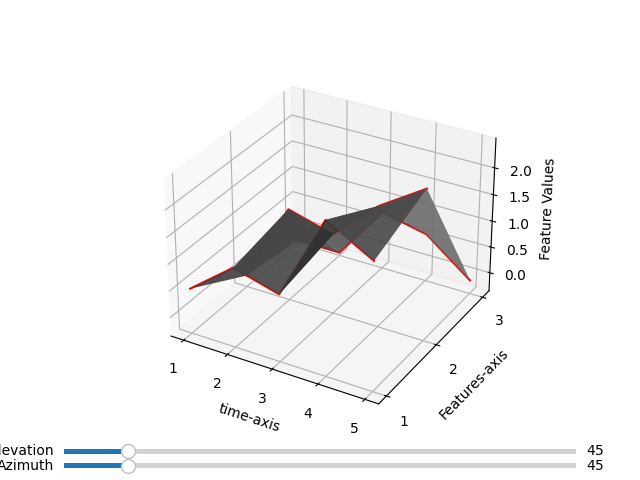

In [52]:
# waterfall plot of a single entity
idx = 0
fig, ax = tsplot.waterfall_plot(X_arr[:, idx, :])

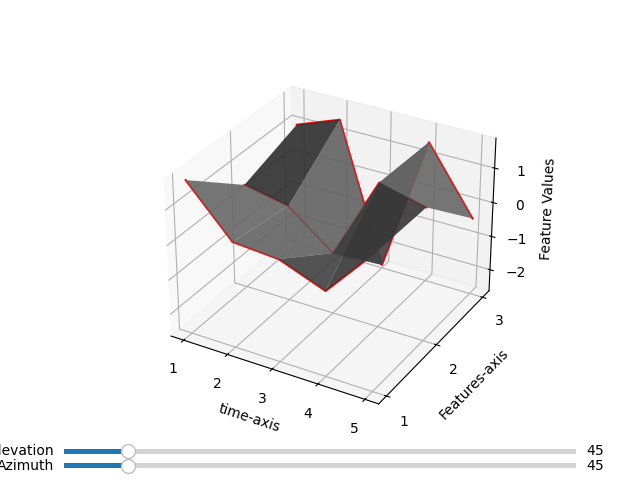

In [53]:
# waterfall plot of a single cluster center
idx = 0
fig, ax = tsplot.waterfall_plot(cluster_centers[:, idx, :])

## Temporal Clustering Models

All temporal clustering modules implements a `fit` method (in which on executing, compute the cluster centers and label assignments).

We can use the `cluster_centers_` and `labels_` attributes to retreive the cluster centers and label assignments respectively. Here we used sklearn's convention of using trailing underscores for attributes whose values are known only after fitting.

### OptTSCluster

**fixed centers, dynamic assignment**

In [54]:
# initialize the model
opt_ts = OptTSCluster(
    k=3, 
    scheme='z0c1', # fixed centers, dynamic assignment
    n_allow_assignment_change=None, # number of changes to allow, None means allow as many changes as possible
    warm_start=True # warm start with kmeans
)

In [55]:
model_size = opt_ts.get_model_size(X_arr)
print(f"model has {model_size[0]} variables and {model_size[1]} constraints")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-18
model has 610 variables and 950 constraints


In [56]:
label_dict

{'T': ['2000', '2005', '2010', '2015', '2020'],
 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
 'F': ['x1', 'x2', 'x3']}

In [57]:
# fit the model
opt_ts.fit(X_arr, label_dict=label_dict); # we can optionally pass the label dict to the model during fit

Warm starting...
Done with warm start after 0.08secs

Obj val: [3.77787002]

Total time is 1.9secs



In [58]:
# checking the label dict
opt_ts.label_dict_

{'T': ['2000', '2005', '2010', '2015', '2020'],
 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
 'F': ['x1', 'x2', 'x3']}

We can get the cluster centers as a dataframe with the labels in `label_dict` 

In [59]:
cluster_centers_lst = opt_ts.get_named_cluster_centers()
cluster_centers_lst[0] # first cluster

x1        x2       x3
2000 -1.585509 -2.543203 -0.63065
2005 -1.585509 -2.543203 -0.63065
2010 -1.585509 -2.543203 -0.63065
2015 -1.585509 -2.543203 -0.63065
2020 -1.585509 -2.543203 -0.63065

We can also get the labels as a dataframe indexed with labels in `label_dict` 

In [60]:
opt_ts.get_named_labels()

2000  2005  2010  2015  2020
i1      2     2     2     2     2
i10     1     1     1     2     2
i2      0     0     0     0     0
i3      2     2     2     0     0
i4      2     2     2     0     0
i5      2     2     1     0     0
i6      2     1     2     2     2
i7      2     0     1     2     2
i8      2     1     1     1     1
i9      1     2     2     2     2

Checking most dynamic entities

In [61]:
print(f"total number of cluster changes is: {opt_ts.n_changes_}")
opt_ts.get_dynamic_entities() # dynamic entities and their number of cluster changes

total number of cluster changes is: 12


(['i7', 'i6', 'i5', 'i9', 'i8', 'i4', 'i3', 'i10'], [3, 2, 2, 1, 1, 1, 1, 1])

In [62]:
# retrieve the cluster centers and labels
cc_opt_ts = opt_ts.cluster_centers_
labels_opt_ts = opt_ts.labels_
labels_opt_ts

array([[2, 2, 2, 2, 2],
       [1, 1, 1, 2, 2],
       [0, 0, 0, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 2, 0, 0],
       [2, 2, 1, 0, 0],
       [2, 1, 2, 2, 2],
       [2, 0, 1, 2, 2],
       [2, 1, 1, 1, 1],
       [1, 2, 2, 2, 2]], dtype=int64)

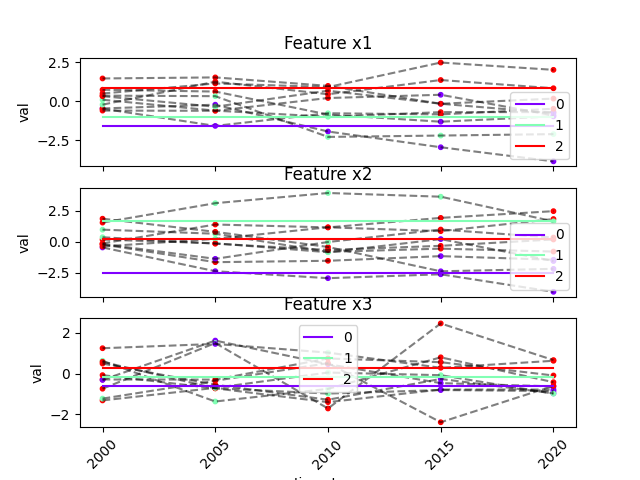

In [63]:
# plot model results
fig, ax = tsplot.plot(X=X_arr, cluster_centers=cc_opt_ts, labels=labels_opt_ts, label_dict=opt_ts.label_dict_)

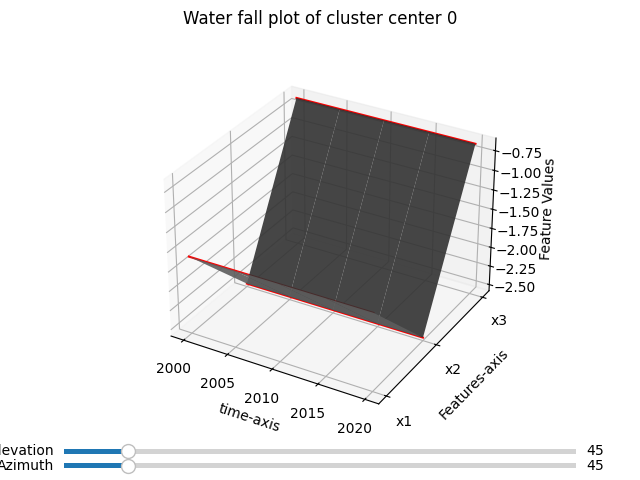

In [64]:
# waterfall plot of a particular cluster center
cc_idx = 0 # index of cluster center to plot
cc = broadcast_data(X_arr.shape[0], cluster_centers=cc_opt_ts)[0][:, cc_idx, :] # broadcasting the cluster center
fig, ax = tsplot.waterfall_plot(cc, label_dict=opt_ts.label_dict_)
fig.suptitle(f"Water fall plot of cluster center {cc_idx}");

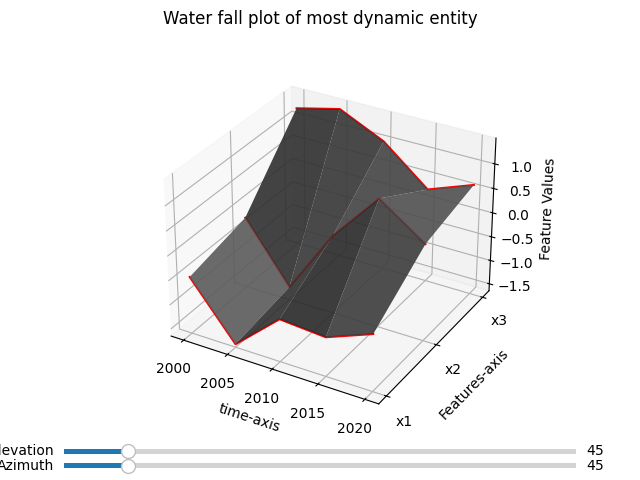

In [65]:
# waterfall plot of most dynamic entity
most_dynamic_entity_idx = np.where(opt_ts.get_named_labels().index == opt_ts.get_dynamic_entities()[0][0])[0][0]
fig, ax = tsplot.waterfall_plot(X_arr[:, most_dynamic_entity_idx, :], label_dict=opt_ts.label_dict_)
fig.suptitle("Water fall plot of most dynamic entity");

In [66]:
# scoring the model
print(f"inertia score is {inertia(X_arr, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance

inertia score is 133.3344058063092
max_dist score is 3.777870015440996


We can also set the label_dict after fitting

In [67]:
old_label_dict = opt_ts.label_dict_
old_label_dict

{'T': ['2000', '2005', '2010', '2015', '2020'],
 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
 'F': ['x1', 'x2', 'x3']}

In [68]:
new_label_dict = {k: v for k, v in old_label_dict.items()}
new_label_dict['F'] = ['A', 'B', 'C']

opt_ts.set_label_dict(new_label_dict)

In [69]:
opt_ts.label_dict_

{'T': ['2000', '2005', '2010', '2015', '2020'],
 'N': ['i1', 'i10', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
 'F': ['A', 'B', 'C']}

**dynamic centers, fixed assignment**

In [70]:
# loading the data
X_arr2, _ = load_data("./sythetic_data.npy")
X_arr2.shape

(10, 15, 1)

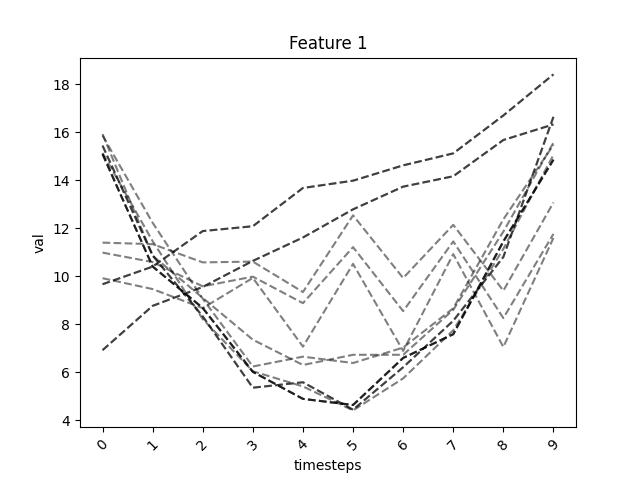

In [71]:
# visualizing the data
fig, ax = tsplot.plot(X=X_arr2)

In [72]:
# initialize the model
opt_ts = OptTSCluster(
    k=3, 
    scheme='z1c1', # dynamic centers, dynamic assignment. Scheme needs to be a dynamic label scheme when using constrained cluster change
                   # you can also use 'z1c0' scheme here
    n_allow_assignment_change=0, # number of changes to allow, 0 means allow as no changes are allowed.
    warm_start=True # warm start with kmeans
)

In [73]:
# checking the size of the model
model_size = opt_ts.get_model_size(X_arr2)
print(f"model has {model_size[0]} variables and {model_size[1]} constraints")

model has 1066 variables and 1051 constraints


In [74]:
# fit the model
opt_ts.fit(X_arr2); 

Warm starting...
Done with warm start after 0.13secs

Obj val: [1.51774178]

Total time is 0.33secs



In [75]:
print(f"total number of cluster changes is: {opt_ts.n_changes_}")
opt_ts.get_dynamic_entities() # indexes of dynamic entities and their number of cluster changes

total number of cluster changes is: 0


([], [])

In [76]:
# retrieve the cluster centers and labels
cc_opt_ts = opt_ts.cluster_centers_
labels_opt_ts = opt_ts.labels_

In [77]:
labels_opt_ts

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

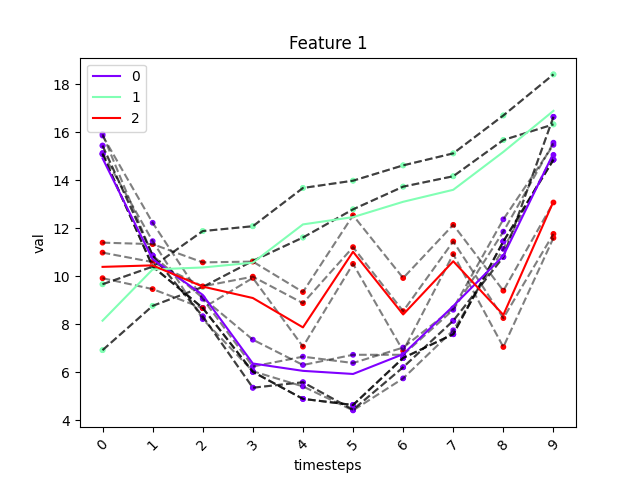

In [78]:
# plot of model results
fig, ax = tsplot.plot(X=X_arr2, cluster_centers=cc_opt_ts, labels=labels_opt_ts)

In [79]:
# scoring the model
print(f"inertia score is {inertia(X_arr2, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr2, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance

inertia score is 117.50053747638934
max_dist score is 1.5177417770731711


#### Lagrangian constrained changes

**Using lagrangian multiplier to penalize cluster changes**

In [80]:
# initialize the model
opt_ts = OptTSCluster(
    k=3, 
    scheme='z1c1', # dynamic centers, dynamic assignment. Scheme needs to be a dynamic label scheme when using constrained cluster change
    lagrangian_multiplier=0.1, # penalty for cluster changes.
    warm_start=True # warm start with kmeans
)

In [81]:
# fit the model
opt_ts.fit(X_arr2);

Warm starting...
Done with warm start after 0.16secs

Obj val: [1.17290776]

Total time is 3.21secs



In [82]:
opt_ts.get_model_size(X_arr2)

(1066, 1050)

In [83]:
print(f"total number of cluster changes is: {opt_ts.n_changes_}")
opt_ts.get_dynamic_entities() # indexes of dynamic entities and their number of cluster changes

total number of cluster changes is: 4


([9, 12, 7], [2, 1, 1])

In [84]:
# retrieve the cluster centers and labels
cc_opt_ts = opt_ts.cluster_centers_
labels_opt_ts = opt_ts.labels_
labels_opt_ts[opt_ts.get_dynamic_entities()[0]]

array([[2, 2, 2, 2, 2, 2, 1, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

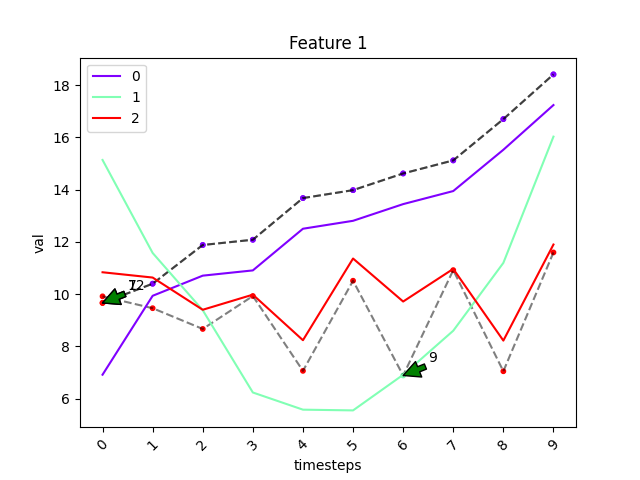

In [86]:
# plot of model results
fig, ax = tsplot.plot(
    X=X_arr2, 
    cluster_centers=cc_opt_ts, 
    labels=labels_opt_ts, 
    entity_idx=opt_ts.get_dynamic_entities()[0], 
    show_all_entities=False
)

In [87]:
# scoring the results
print(f"inertia score is {inertia(X_arr2, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr2, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance

inertia score is 100.24600042840666
max_dist score is 1.172907757906195


#### Hard constrained changes

**Creating dynamic entities**

In [88]:
dynamic_X1 = np.concatenate([X_arr2[:3, 0, :], X_arr2[3:, 2, :]], axis=0)[:, np.newaxis, :]
dynamic_X2 = np.concatenate([X_arr2[:6, 6, :], X_arr2[6:, 4, :]], axis=0)[:, np.newaxis, :]

In [89]:
X_arr3 = np.concatenate([X_arr2, dynamic_X1, dynamic_X2], axis=1)
X_arr3.shape

(10, 17, 1)

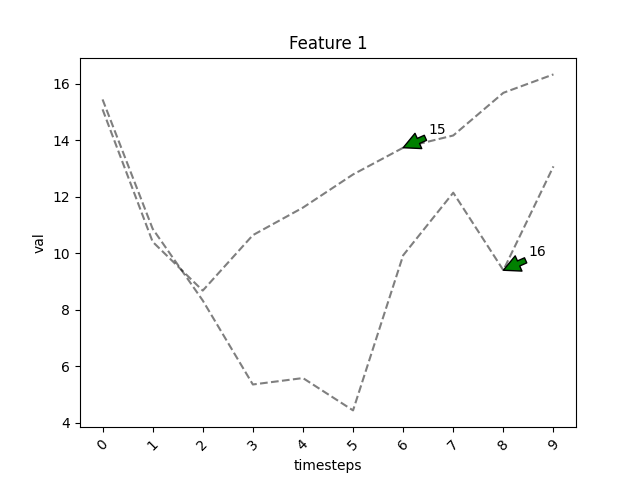

In [90]:
# plotting the synthetically created dynamic entities
fig, ax = tsplot.plot(X=X_arr3, entity_idx=np.arange(X_arr2.shape[1], X_arr3.shape[1]), show_all_entities=False)

In [91]:
# initialize the model
opt_ts = OptTSCluster(
    k=3, 
    scheme='z1c1', # dynamic centers, dynamic assignment. Scheme needs to be a dynamic label scheme when using constrained cluster change
    n_allow_assignment_change=2, # number of changes to allow, None means allow as many changes as possible
    warm_start=True # warm start with kmeans
)

In [92]:
# fit the model
opt_ts.fit(X_arr3);

Warm starting...
Done with warm start after 0.13secs

Obj val: [1.51774178]

Total time is 12.17secs



In [93]:
print(f"total number of cluster changes is: {opt_ts.n_changes_}")
opt_ts.get_dynamic_entities() # indexes of dynamic entities and their number of cluster changes

total number of cluster changes is: 2


([16, 15], [1, 1])

In [94]:
# retrieve the cluster centers and labels
cc_opt_ts = opt_ts.cluster_centers_
labels_opt_ts = opt_ts.labels_

# labels of dynamic entities
labels_opt_ts[opt_ts.get_dynamic_entities()[0]]

array([[0, 0, 0, 0, 0, 0, 2, 2, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]], dtype=int64)

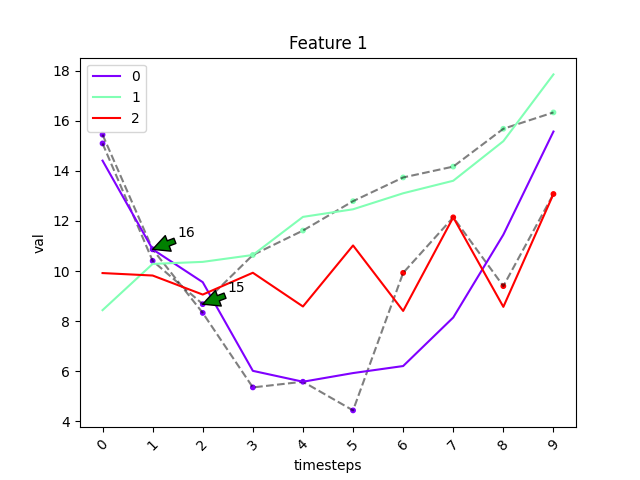

In [95]:
# plot of model results
fig, ax = tsplot.plot(
    X=X_arr3, 
    cluster_centers=cc_opt_ts, 
    labels=labels_opt_ts, 
    entity_idx=opt_ts.get_dynamic_entities()[0], 
    show_all_entities=False
)

In [96]:
# scoring the results
print(f"inertia score is {inertia(X_arr3, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr3, cc_opt_ts, labels_opt_ts, ord=1)}") # using l1 distance

inertia score is 126.276243984816
max_dist score is 1.517741777073173


In [97]:
# checking the default label_dict (since we did not set the label dict or pass any during fit)
print(opt_ts.label_dict_)

{'T': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'F': [0]}


### TSGlobalKmeans

This module applies sklearn's k-mean clustering to the data resulting from concatenating along the time axis. 

In [98]:
# initialize the model
g_ts_km = TSGlobalKmeans(n_clusters=3)

In [99]:
# fit the model
g_ts_km.fit(X_arr3);

In [100]:
print(f"total number of cluster changes is: {g_ts_km.n_changes_}")
g_ts_km.get_dynamic_entities() # indexes of dynamic entities and their number of cluster changes

total number of cluster changes is: 53


([9, 16, 10, 1, 6, 8, 11, 13, 14, 0, 15, 5, 3, 2, 12, 7, 4],
 [6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 1, 1])

In [101]:
# retrieve the cluster centers and labels
cc_g_ts_km = g_ts_km.cluster_centers_
labels_g_ts_km = g_ts_km.labels_

# labels of dynamic entities
labels_g_ts_km[g_ts_km.get_dynamic_entities()[0]]

array([[0, 0, 0, 0, 2, 0, 2, 0, 2, 0],
       [1, 0, 0, 2, 2, 2, 0, 0, 0, 1],
       [1, 0, 2, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 0, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 0, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 2, 2, 2, 2, 2, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [2, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

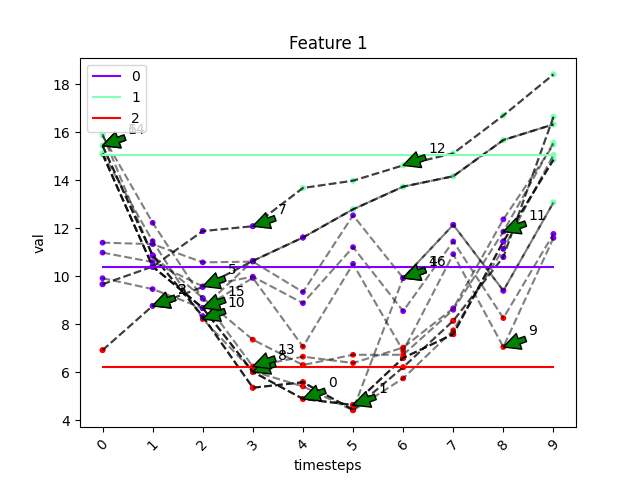

In [102]:
# plot of model results
fig, ax = tsplot.plot(
    X=X_arr3, 
    cluster_centers=cc_g_ts_km, 
    labels=labels_g_ts_km, 
    entity_idx=g_ts_km.get_dynamic_entities()[0], 
    show_all_entities=False
)

In [103]:
# scoring the results
print(f"inertia score is {inertia(X_arr3, cc_g_ts_km, labels_g_ts_km, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr3, cc_g_ts_km, labels_g_ts_km, ord=1)}") # using l1 distance

inertia score is 166.82397817096967
max_dist score is 3.3717592522248783


### TSKmeans

This module applies tslearn's time series k-mean clustering to the data.

In [104]:
# initialize the model
ts_km = TSKmeans(n_clusters=3)

In [105]:
# fit the model
ts_km.fit(X_arr3);

In [106]:
print(f"total number of cluster changes is: {ts_km.n_changes_}")
ts_km.get_dynamic_entities() # indexes of dynamic entities and their number of cluster changes

total number of cluster changes is: 0


([], [])

In [107]:
# retrieve the cluster centers and labels
cc_ts_km = ts_km.cluster_centers_
labels_ts_km = ts_km.labels_

# labels of dynamic entities
labels_ts_km[ts_km.get_dynamic_entities()[0]]

array([], dtype=int64)

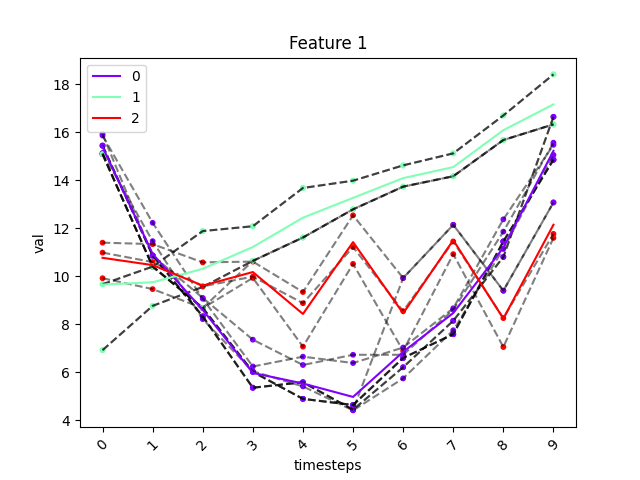

In [110]:
# plot of model results
fig, ax = tsplot.plot(
    X=X_arr3, 
    cluster_centers=cc_ts_km, 
    labels=labels_ts_km
)

In [109]:
# scoring the results
print(f"inertia score is {inertia(X_arr3, cc_ts_km, labels_ts_km, ord=1)}") # using l1 distance
print(f"max_dist score is {max_dist(X_arr3, cc_ts_km, labels_ts_km, ord=1)}") # using l1 distance

inertia score is 113.52000410204052
max_dist score is 5.437567193350128
